**Copyright 2021 The TensorFlow Authors.**

In [13]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/models/tree/master/official/colab/vision/vit_deit_augmentations.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/models/tree/master/official/colab/vision/vit_deit_augmentations.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

## Installation from source

In [2]:
# Clone repository and pull latest changes.
![ -d models ] || git clone --depth=1 https://github.com/sigeisler/models
!cd /content/models/ && git pull

Cloning into 'models'...
remote: Enumerating objects: 3075, done.
remote: Counting objects: 100% (3075/3075), done.
remote: Compressing objects: 100% (2603/2603), done.
remote: Total 3075 (delta 772), reused 1324 (delta 429), pack-reused 0
Receiving objects: 100% (3075/3075), 33.32 MiB | 26.62 MiB/s, done.
Resolving deltas: 100% (772/772), done.
Already up to date.


In [3]:
%cd models/

/content/models


In [4]:
import os
os.environ['PYTHONPATH'] += ":/content/models"

In [5]:
!pip install tensorflow_addons
#!pip uninstall -y tensorflow keras tensorflow-addons tensorboard && pip install tf-nightly tensorflow-text-nightly tfa-nightly tfds-nightly
!pip install --user -r official/requirements.txt

     |████████████████████████████████| 1.1 MB 5.3 MB/s 
Ignoring dataclasses: markers 'python_version < "3.7"' don't match your environment
     |████████████████████████████████| 99 kB 3.2 MB/s 
     |████████████████████████████████| 213 kB 26.9 MB/s 
     |████████████████████████████████| 352 kB 32.1 MB/s 
     |████████████████████████████████| 636 kB 41.0 MB/s 
     |████████████████████████████████| 47.6 MB 132 kB/s 
     |████████████████████████████████| 43 kB 848 kB/s 
     |████████████████████████████████| 1.2 MB 42.5 MB/s 
     |████████████████████████████████| 90 kB 9.8 MB/s 
  Created wheel for py-cpuinfo: filename=py_cpuinfo-8.0.0-py3-none-any.whl size=22258 sha256=93410d5a70f6f41543d70a2edef6a7397998b7b16c016c3e0572ac21eec1035d
  Stored in directory: /root/.cache/pip/wheels/d2/f1/1f/041add21dc9c4220157f1bd2bd6afe1f1a49524c3396b94401
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16181 sha256=69ab455799a3c4568ee5cd5675c66f3da19cb41e960d02d77

In [6]:
import tensorflow_addons

In [7]:
from official.vision.beta.dataloaders.classification_input import Decoder, Parser, MEAN_RGB, STDDEV_RGB
from official.vision.beta.dataloaders import tfds_factory
from official.vision.beta.configs import common
from official.vision.beta.ops.augment import MixupAndCutmix
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tqdm.notebook import tqdm
from skimage import io

# Donwload Sample Images

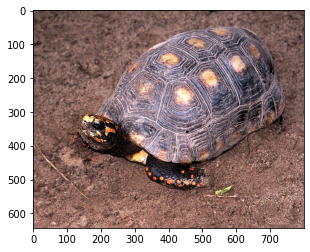

In [8]:
image_urls = [
  "https://farm5.staticflickr.com/7483/15493228888_0a8c187ae6_o.jpg",
  "https://c8.staticflickr.com/9/8566/16689715816_0c64e496a3_o.jpg",
  "https://farm9.staticflickr.com/8391/8582971333_894c9407e5_z.jpg",
  "https://farm3.staticflickr.com/2571/3834815520_c366224405_z.jpg"
]
images = [io.imread(image_url) for image_url in image_urls]

plt.imshow(images[0])

images = [tf.io.encode_png(image) for image in images]

n_images = len(images)
assert n_images % 2 == 0

In [9]:
dataset = tf.data.Dataset.from_tensor_slices({"image/encoded": images, "image/class/label": [0] * n_images})

# Augment Images

In [10]:
augmentations = {
  'Default': dict(
    parser=Parser(output_size=(224, 224),
                  num_classes=100,
                  decode_jpeg_only=False).parse_fn(True),
    mixup_and_cutmix=None
  ),
  'Color Jitter': dict(
    parser=Parser(output_size=(224, 224),
                  color_jitter=0.4,
                  num_classes=100,
                  decode_jpeg_only=False).parse_fn(True),
    mixup_and_cutmix=None
  ),
  'Random Erasing': dict(
    parser=Parser(output_size=(224, 224),
                  random_erasing=common.RandomErasing,
                  num_classes=100,
                  decode_jpeg_only=False).parse_fn(True),
    mixup_and_cutmix=None
  ),
  'Rand Augment': dict(
    parser=Parser(output_size=(224, 224),
                  aug_type=common.Augmentation(type='randaug', randaug=common.RandAugment(magnitude=9, exclude_ops=['Cutout'])),
                  num_classes=100,
                  decode_jpeg_only=False).parse_fn(True),
    mixup_and_cutmix=None
  ),
  'Mixup': dict(
    parser=Parser(output_size=(224, 224),
                  num_classes=100,
                  decode_jpeg_only=False).parse_fn(True),
    mixup_and_cutmix=MixupAndCutmix(cutmix_alpha=0)
  ),
  'Cutmix': dict(
    parser=Parser(output_size=(224, 224),
                  num_classes=100,
                  decode_jpeg_only=False).parse_fn(True),
    mixup_and_cutmix=MixupAndCutmix(mixup_alpha=0)
  ),
  'All': dict(
    parser=Parser(output_size=(224, 224),
                  num_classes=100,
                  aug_type=common.Augmentation(type='randaug', randaug=common.RandAugment(magnitude=9, exclude_ops=['Cutout'])),
                  color_jitter=0.4,
                  random_erasing=common.RandomErasing,
                  decode_jpeg_only=False).parse_fn(True),
    mixup_and_cutmix=MixupAndCutmix()
  )
}

In [11]:
augmented_images = {}

for name, augmentation in tqdm(augmentations.items()):
  images_and_labels = list(
      dataset
      #.map(decoder)
      .map(augmentation['parser'])
      .take(n_images).as_numpy_iterator()
  )

  augmented_images[name] = []
  for i in range(n_images):
    if augmentation['mixup_and_cutmix'] is not None:
      image1, label1 = images_and_labels[i]
      image2, label2 = images_and_labels[n_images - i - 1]
      images = tf.stack((image1, image2), axis=0)
      labels = tf.stack((label1, label2), axis=0)

      image = augmentation['mixup_and_cutmix'](images, labels)[0][0]
    else:
      image = images_and_labels[i][0]

    image = tf.cast(image * STDDEV_RGB + MEAN_RGB, tf.uint8)

    augmented_images[name].append(image)


  0%|          | 0/7 [00:00<?, ?it/s]

# Compare Augmented Images

(Additionally we perform random horizontal flips)

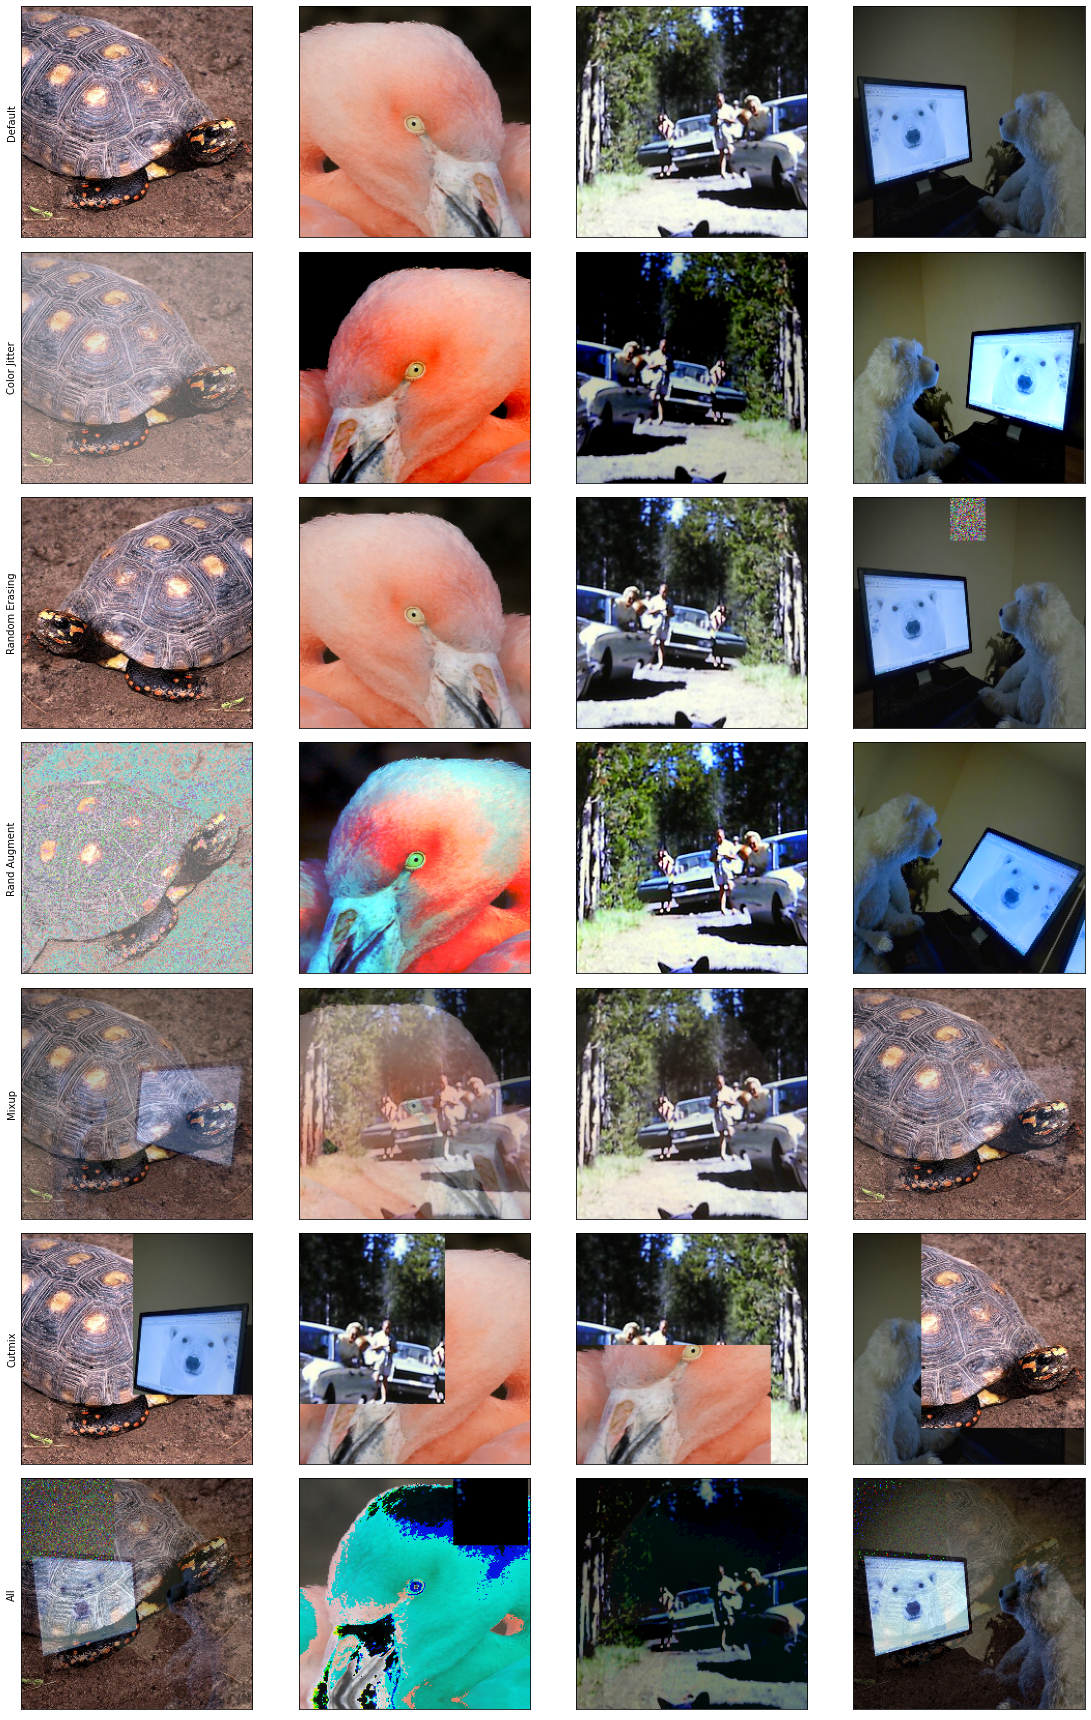

In [12]:
fig = plt.figure(figsize=(16,24))
for i in range(n_images):
  for j, augmentation in enumerate(augmentations.keys()):
    sub = fig.add_subplot(len(augmentations), n_images, j * n_images + i + 1)
    sub.imshow(augmented_images[augmentation][i])
    if i == 0:
      #sub.set_title(augmentation)
      sub.set_ylabel(augmentation)

    sub.axes.get_xaxis().set_visible(False)
    #sub.axes.get_yaxis().set_visible(False)
    sub.set_yticks([])


fig.tight_layout()

fig.show()